## Preparation of data

### Labeling Data and converting images to array values

In [1]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import asarray
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [3]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data (path,label_path):
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv(label_path, 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function(path)

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [4]:
#load data and shuffle them around
df = load_img_data('DIDA_12000_String_Digit_Images/DIDA_1','DIDA_12000_String_Digit_Labels.csv')
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,6491,1840,0,4,0,"[[[133.0], [133.0], [133.0], [133.0], [130.0],...",6491.jpg
1,4380,1830,0,3,0,"[[[178.0], [178.0], [178.0], [178.0], [178.0],...",4380.jpg
2,9194,203170,1,10,10,"[[[184.0], [187.0], [185.0], [186.0], [183.0],...",9194.jpg
3,91,1839,0,3,9,"[[[177.0], [191.0], [180.0], [169.0], [183.0],...",91.jpg
4,9702,1803,0,0,3,"[[[151.0], [154.0], [157.0], [131.0], [148.0],...",9702.jpg
...,...,...,...,...,...,...,...
11995,9852,1836,0,3,6,"[[[150.0], [150.0], [155.0], [152.0], [156.0],...",9852.jpg
11996,1684,1810,0,1,0,"[[[123.0], [124.0], [123.0], [119.0], [122.0],...",1684.jpg
11997,4451,1816,0,1,6,"[[[199.0], [200.0], [199.0], [200.0], [201.0],...",4451.jpg
11998,866,1833,0,3,3,"[[[129.0], [126.0], [128.0], [127.0], [126.0],...",866.jpg


### Defining fixed train, test and valdiation sets.

In [5]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [6]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [7]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [8]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 2.3, Testing the final models

### Initializing CNN's

In [9]:
import tensorflow as tf
import data_loader as dl
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.03, input_shape=(56, 106, 1))
    ])


#### Model CC

In [6]:
### With Augmentation
model_CC_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_CC_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

history_CC_aug = model_CC_aug.fit(x_train, CC_train, validation_data=(x_val, CC_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_CC_aug.history['loss'], label='Training loss')
ax.plot(history_CC_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model CC')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_CC_aug.history['accuracy'], label='Train accuracy')
ax.plot(history_CC_aug.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model CC')

plt.show()


NameError: name 'x_train' is not defined

Valdiation accuracy, before in report 0.9895

In [13]:
history_CC_aug.history['val_accuracy'][-1]

0.9932291507720947

Validation loss, before in report 0.0465

In [14]:
history_CC_aug.history['val_loss'][-1]

0.022422373294830322

#### Model D

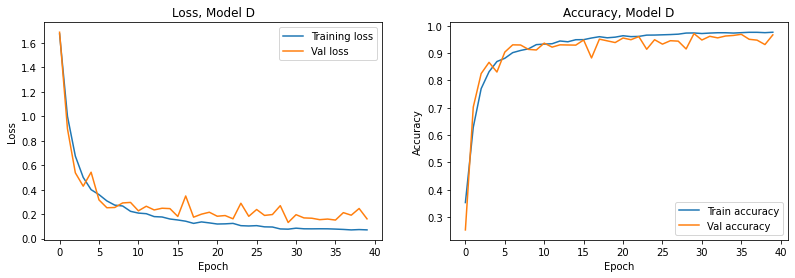

In [15]:
### With Augmentation
model_D_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Flatten
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_D_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_D_aug = model_D_aug.fit(x_train, D_train, validation_data=(x_val, D_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_D_aug.history['loss'], label='Training loss')
ax.plot(history_D_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_D_aug.history['accuracy'], label='Train accuracy')
ax.plot(history_D_aug.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()


Valdiation accuracy, before in report 0.9494

In [16]:
history_D_aug.history['val_accuracy'][-1]

0.9666666388511658

Validation loss, before in report 0.1805

In [17]:
history_D_aug.history['val_loss'][-1]

0.16185861825942993

#### Model Y

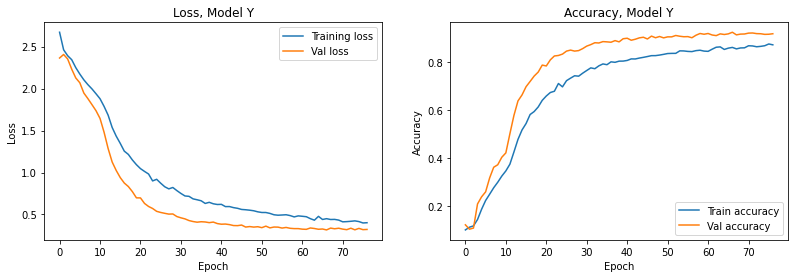

In [18]:
### With Augmentation
model_Y_aug = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(11, activation='softmax'),
    ])

model_Y_aug.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0008),
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
    ) 

history_Y_aug = model_Y_aug.fit(x_train, Y_train, validation_data=(x_val, Y_val), epochs=100, verbose=0,
                   callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

############################

fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(history_Y_aug.history['loss'], label='Training loss')
ax.plot(history_Y_aug.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model Y')

ax = fig.add_subplot(1, 2, 2)
ax.plot(history_Y_aug.history['accuracy'], label='Train accuracy')
ax.plot(history_Y_aug.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model Y')

plt.show()


Validation accuracy, before in report 0.9171

In [19]:
history_Y_aug.history['val_accuracy'][-1]

0.9192708134651184

Validation loss, before in report 0.3898

In [20]:
history_Y_aug.history['val_loss'][-1]

0.3214839994907379

### Measurign test set accuracy

In [23]:
CC_test_acc = model_CC_aug.evaluate(x_test,CC_test)
D_test_acc = model_D_aug.evaluate(x_test,D_test)
Y_test_acc = model_Y_aug.evaluate(x_test,Y_test)
print(CC_test_acc)
print(D_test_acc)
print(Y_test_acc)

75/75 [==============================] - 0s 5ms/step - loss: 0.3498 - accuracy: 0.9204: 0s - loss: 0.3130 - accuracy: 
[0.038886893540620804, 0.9925000071525574]
[0.1640990823507309, 0.9708333611488342]
[0.3497786521911621, 0.9204166531562805]


In [26]:
def accuracy_calc(model,y_test,x_test):
    preds = model.predict(x_test)
    classes = np.argmax(preds, axis = 1)
    score = 0.0
    i = 0
    for row in y_test:
        if int(row) == classes[i]:
            score = score + (1/3)
        i= i + 1
    return score

In [151]:
test_score_CC = accuracy_calc(model_CC_aug,CC_test,x_test)
test_score_D = accuracy_calc(model_D_aug,D_test,x_test)
test_score_Y = accuracy_calc(model_Y_aug,Y_test,x_test)
print(test_score_CC)
print(test_score_D)
print(test_score_Y)
score = ((test_score_Y+test_score_CC+test_score_D)/len(Y_test))*100
score

771.3333333333511
776.666666666685
736.3333333333471


95.18055555555765

In [72]:
array = np.array(CC_test)
print(array)

[0 0 0 ... 0 0 0]


In [155]:
def sequence_calc(model_CC,model_D,model_Y,CC_test,D_test,Y_test,x_test):
    preds_CC = model_CC.predict(x_test)
    preds_D = model_D.predict(x_test)
    preds_Y = model_Y.predict(x_test)
    classes_CC = np.argmax(preds_CC, axis = 1)
    classes_D = np.argmax(preds_D, axis = 1)
    classes_Y = np.argmax(preds_Y, axis = 1)
    CC_array = np.array(CC_test)
    D_array = np.array(D_test)
    Y_array = np.array(Y_test)
    score = 0.0
    i = 0
    while i < len(CC_array):
        if int(CC_array[i]) == classes_CC[i]:
            if int(D_array[i]) == classes_D[i]:
                if int(Y_array[i]) == classes_Y[i]:
                    score = score + 1
        i= i + 1
    return score


In [148]:
seq_acc = (sequence_calc(model_CC_aug,model_D_aug,model_Y_aug,CC_test,D_test,Y_test,x_test)/len(CC_test))*100
seq_acc

87.54166666666666

## 30k Test set 

In [21]:
Hee_csv = pd.read_csv('30_samples_labeled_csv.csv',header=None, names=["index", "string"],delimiter=';')
Hee_csv['CC'] = 0
Hee_csv['D'] = 0
Hee_csv['Y'] = 0
Hee_csv = Hee_csv.astype(str)
# Iterate string digits and append classes
for i, row in Hee_csv.iterrows():
    if len(row['string']) != 4:
        row['CC'] = '1'
        row['D'] = '10'
        row['Y'] = '10'
    else:
        row['D'] = row['string'][2]
        row['Y'] = row['string'][3]
        if row['string'][0:2] == '18':
            row['CC']='0'
        else:
            row['CC']='1'
print(Hee_csv)

      index string CC   D   Y
0     70127   1832  0   3   2
1     70151    252  1  10  10
2     70161   1813  0   1   3
3     70162   1813  0   1   3
4     70180   1817  0   1   7
..      ...    ... ..  ..  ..
995  100016   1895  0   9   5
996  100032   1896  0   9   6
997  100085   1896  0   9   6
998  100120   1897  0   9   7
999  100199   1896  0   9   6

[1000 rows x 5 columns]


In [22]:
#os.chdir(path_images)
image_array, filename = load_image_function('30_samples')

# and convert to a img_df
img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                        columns=['filename', 'img_value'])
# Create proper index value in img_df to allow merge on Hee_csv
img_df['index'] = img_df['filename']
for i, row in img_df.iterrows():
    row['index'] = str(img_df['index'][i]).split('.')[0]
img_df
# End of creating img_df
#
# Start: merge img_df with Hee_csv
# match index type on dataframes to merge
Hee_csv['index'] = Hee_csv['index'].astype(int)
img_df['index'] = img_df['index'].astype(int)
# Merge dataframes
df_img_classes = Hee_csv.merge(img_df)
# Rearrange order of dataframe
df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
# End og merging data frames

In [23]:
df_img_classes

,index,string,CC,D,Y,img_value,filename
0,70127,1832,0,3,2,"[[[148.0], [147.0], [150.0], [148.0], [149.0],...",70127.jpg
1,70151,252,1,10,10,"[[[123.0], [102.0], [59.0], [62.0], [76.0], [9...",70151.jpg
2,70161,1813,0,1,3,"[[[18.0], [19.0], [14.0], [18.0], [21.0], [21....",70161.jpg
3,70162,1813,0,1,3,"[[[39.0], [38.0], [32.0], [38.0], [35.0], [35....",70162.jpg
4,70180,1817,0,1,7,"[[[116.0], [121.0], [121.0], [126.0], [124.0],...",70180.jpg
...,...,...,...,...,...,...,...
995,100016,1895,0,9,5,"[[[192.0], [192.0], [193.0], [194.0], [194.0],...",100016.jpg
996,100032,1896,0,9,6,"[[[194.0], [194.0], [194.0], [194.0], [194.0],...",100032.jpg
997,100085,1896,0,9,6,"[[[187.0], [186.0], [187.0], [189.0], [187.0],...",100085.jpg
998,100120,1897,0,9,7,"[[[186.0], [188.0], [188.0], [187.0], [186.0],...",100120.jpg


In [24]:
k30_labels_CC = df_img_classes['CC']
k30_labels_D = df_img_classes['D']
k30_labels_Y = df_img_classes['Y']


In [25]:
k30_img_vals =  df_img_classes['img_value']
values = np.zeros(shape=(len(k30_img_vals),56,106,1))
i = 0
j = 0
while i < len(k30_img_vals):
    values[i] = k30_img_vals[j]
    i += 1
    j+=1
k30_img_vals = values/255


### sequence accuracy = 61.1%

In [156]:
seq_acc = (sequence_calc(model_CC_aug,model_D_aug,model_Y_aug,k30_labels_CC,k30_labels_D,k30_labels_Y,k30_img_vals)/len(k30_img_vals))*100
seq_acc

61.1

### Character accuracy 80.9%

In [152]:
test_score_CC = accuracy_calc(model_CC_aug,k30_labels_CC,k30_img_vals)
test_score_D = accuracy_calc(model_D_aug,k30_labels_D,k30_img_vals)
test_score_Y = accuracy_calc(model_Y_aug,k30_labels_Y,k30_img_vals)
print(test_score_CC)
print(test_score_D)
print(test_score_Y)
score = ((test_score_Y+test_score_CC+test_score_D)/len(k30_img_vals))*100
score

271.00000000000205
275.33333333333513
262.6666666666692


80.90000000000063

In [14]:
loaded_D  = tf.keras.models.load_model('models/D_CNN_Final.h5')
loaded_Y = tf.keras.models.load_model('models/Y_CNN_Final.h5')
loaded_CC = tf.keras.models.load_model('models/CC_CNN_Final.h5')

In [77]:
test_score_CC = accuracy_calc(loaded_CC,k30_labels_CC,k30_img_vals)
test_score_D = accuracy_calc(loaded_D,k30_labels_D,k30_img_vals)
test_score_Y = accuracy_calc(loaded_Y,k30_labels_Y,k30_img_vals)
print(test_score_CC)
print(test_score_D)
print(test_score_Y)
score = ((test_score_Y+test_score_CC+test_score_D)/len(k30_img_vals))*100
score

271.00000000000205
275.33333333333513
262.6666666666692


80.90000000000063

#### Feature Map model: D

In [82]:
for i in range(len(loaded_D.layers)):
    layer = loaded_D.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d_4 (None, 54, 104, 32)
4 conv2d_5 (None, 25, 50, 64)
7 conv2d_6 (None, 10, 23, 128)
11 conv2d_7 (None, 3, 9, 256)


In [83]:
visualize_layer0 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[1].output)
visualize_layer3 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[4].output)
visualize_layer6 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[7].output)
visualize_layer9 = tf.keras.Model(inputs=loaded_D.inputs , outputs=loaded_D.layers[11].output)

In [84]:
image = x_train[1]
image = image.reshape(1,56,106,1)

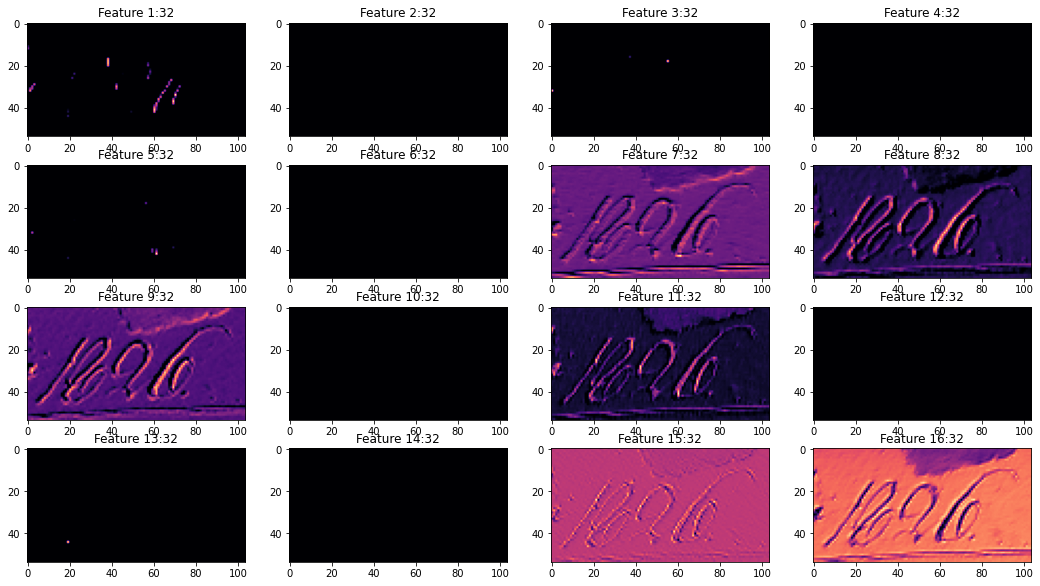

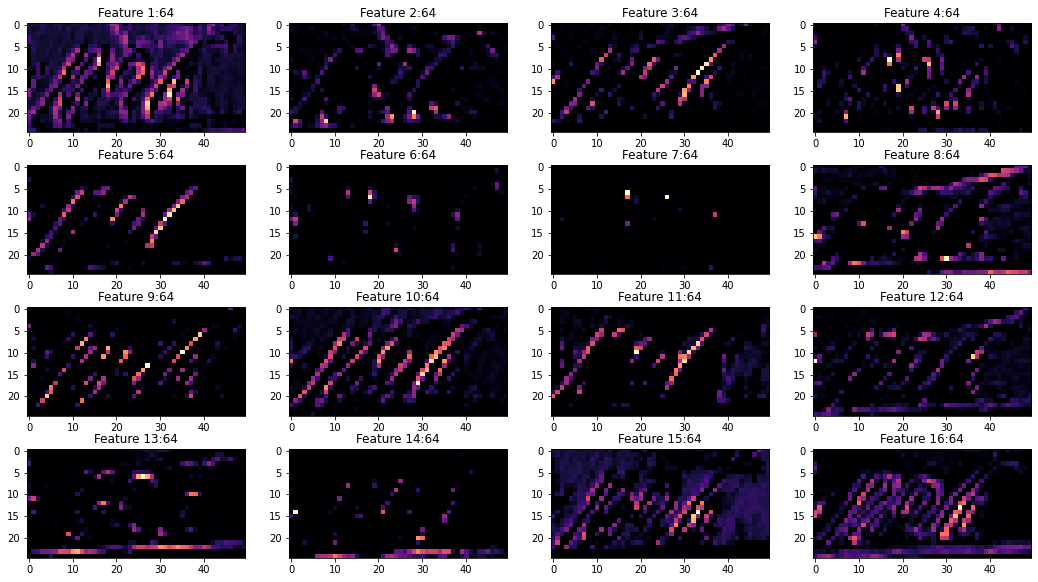

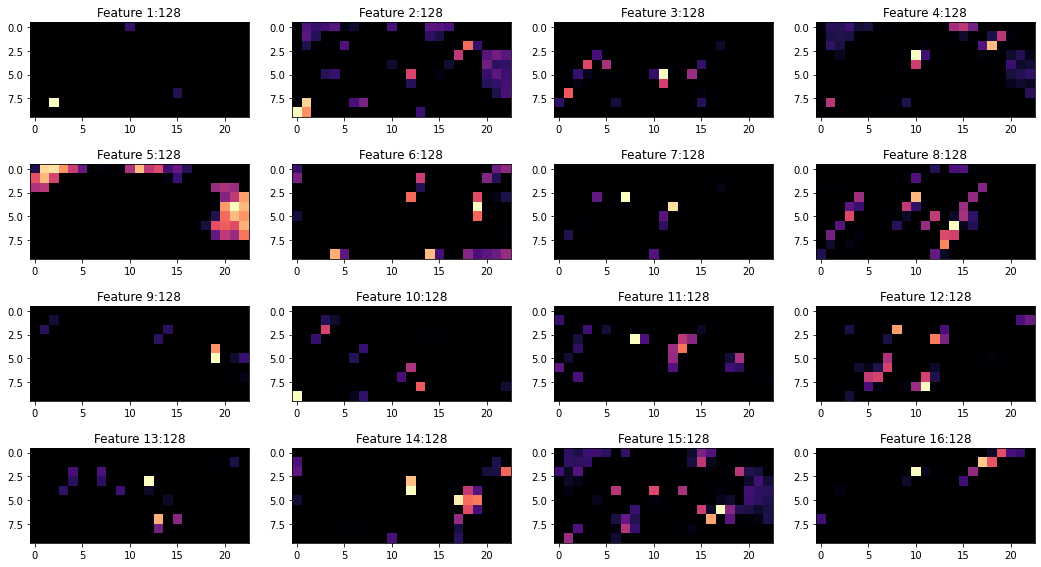

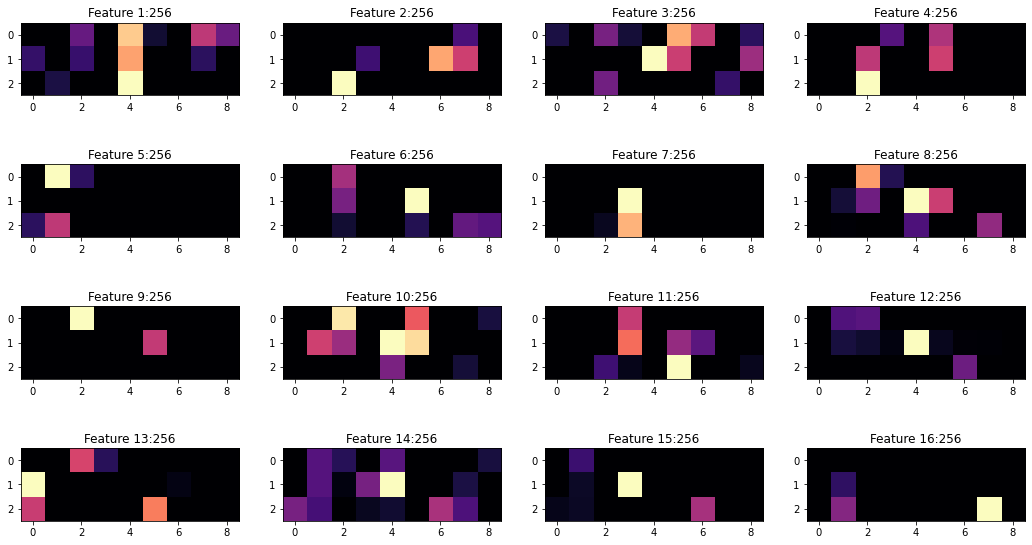

In [85]:
#Visualize feature maps for convolutional layers
layers = [visualize_layer0.predict(image), visualize_layer3.predict(image), visualize_layer6.predict(image),visualize_layer9.predict(image)]
layer_size = [32,64,128,256]
n = 0

for layer in layers:
    plt.figure(figsize=(18,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(layer[0,:,:,i-1] , cmap='magma')
        layer_num = 'Feature '+str(i)+':'+str(layer_size[n])
        plt.title(layer_num)    
    n+=1
    plt.show()

#### Feature Map Model: Y

In [65]:
for i in range(len(loaded_Y.layers)):
    layer = loaded_Y.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d_8 (None, 54, 104, 32)
5 conv2d_9 (None, 25, 50, 64)
9 conv2d_10 (None, 10, 23, 128)
13 conv2d_11 (None, 3, 9, 256)


In [66]:
visualize_layer0 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[1].output)
visualize_layer3 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[5].output)
visualize_layer6 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[9].output)
visualize_layer9 = tf.keras.Model(inputs=loaded_Y.inputs , outputs=loaded_Y.layers[13].output)

In [67]:
image = x_train[1]
image = image.reshape(1,56,106,1)

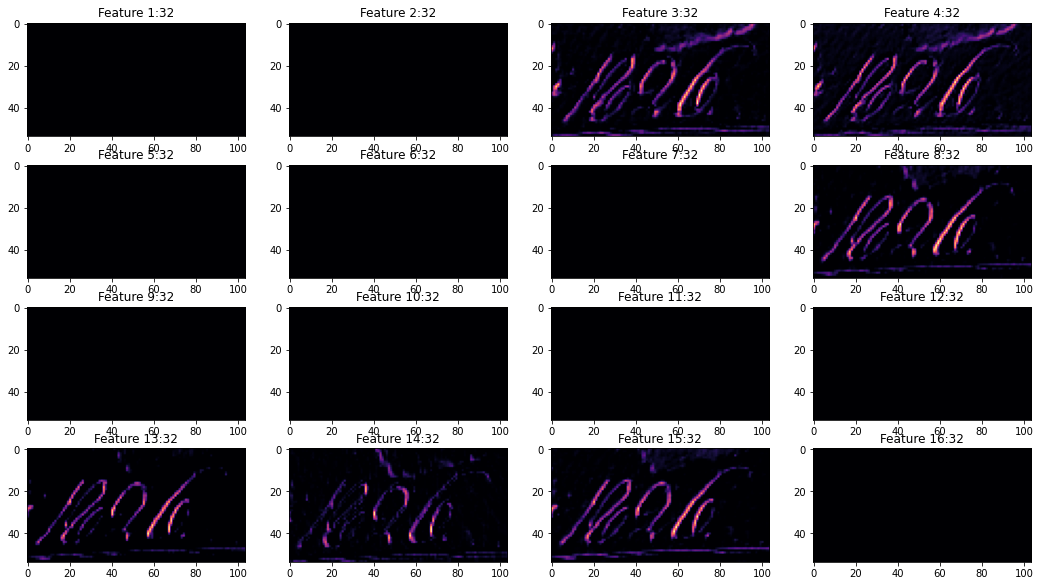

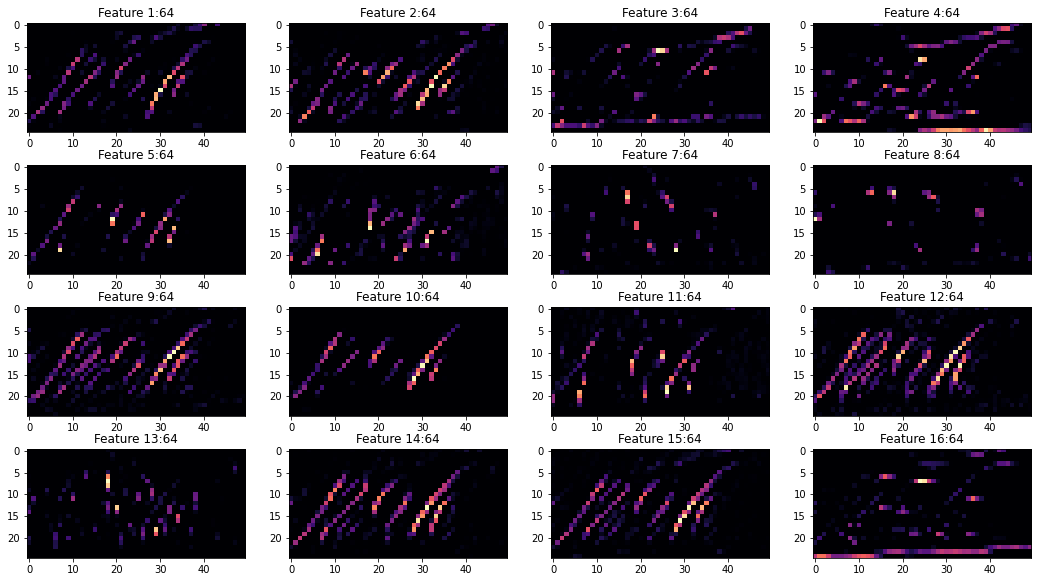

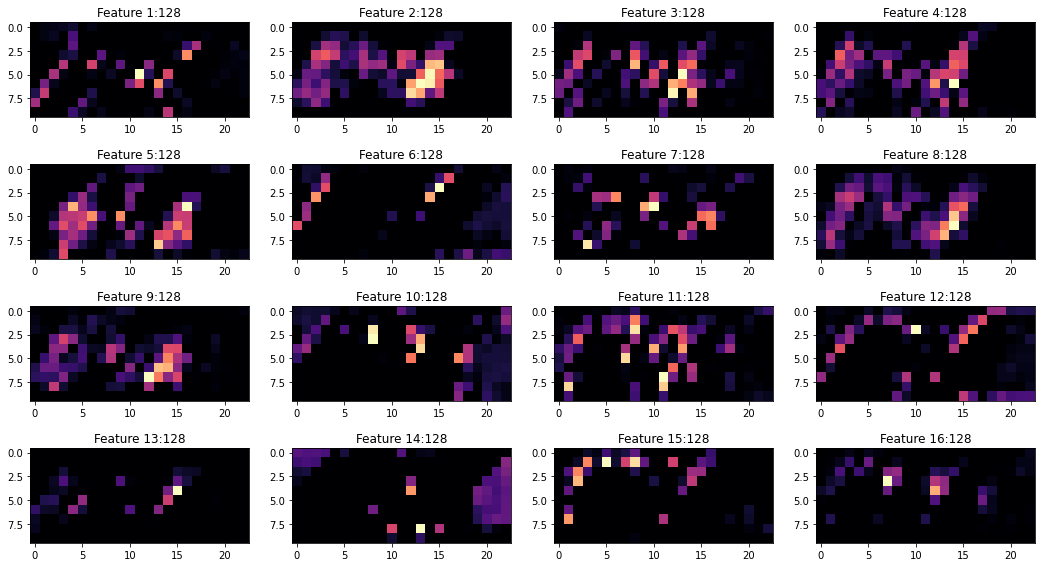

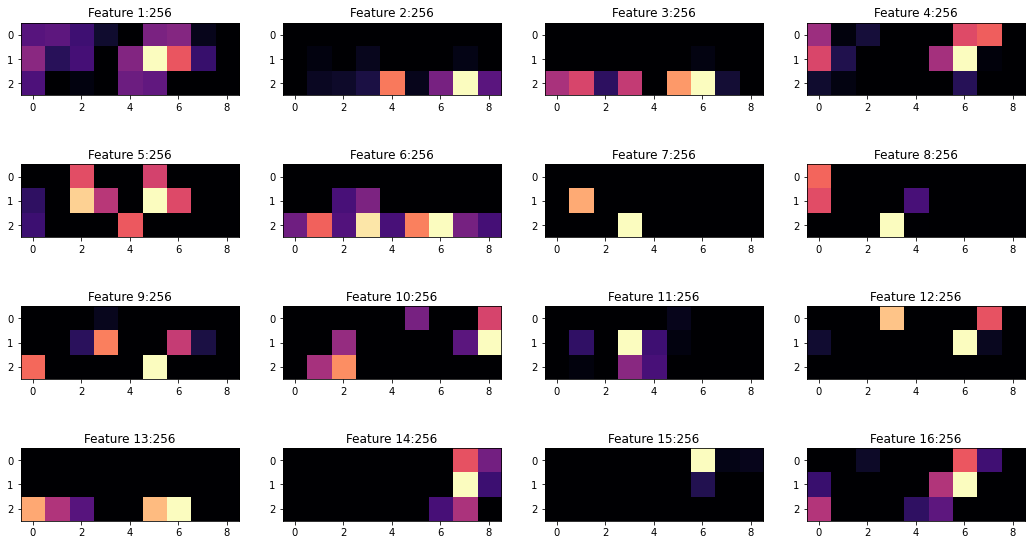

In [68]:
#Visualize feature maps for convolutional layers
layers = [visualize_layer0.predict(image), visualize_layer3.predict(image), visualize_layer6.predict(image),visualize_layer9.predict(image)]
layer_size = [32,64,128,256]
n = 0

for layer in layers:
    plt.figure(figsize=(18,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(layer[0,:,:,i-1] , cmap='magma')
        layer_num = 'Feature '+str(i)+':'+str(layer_size[n])
        plt.title(layer_num)    
    n+=1
    plt.show()

#### Feature Map Model: CC

In [78]:
for i in range(len(loaded_CC.layers)):
    layer = loaded_CC.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

1 conv2d (None, 54, 104, 32)
5 conv2d_1 (None, 25, 50, 64)
9 conv2d_2 (None, 10, 23, 128)
13 conv2d_3 (None, 3, 9, 256)


In [79]:
visualize_layer0 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[1].output)
visualize_layer3 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[5].output)
visualize_layer6 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[9].output)
visualize_layer9 = tf.keras.Model(inputs=loaded_CC.inputs , outputs=loaded_CC.layers[13].output)

In [80]:
image = x_train[1]
image = image.reshape(1,56,106,1)

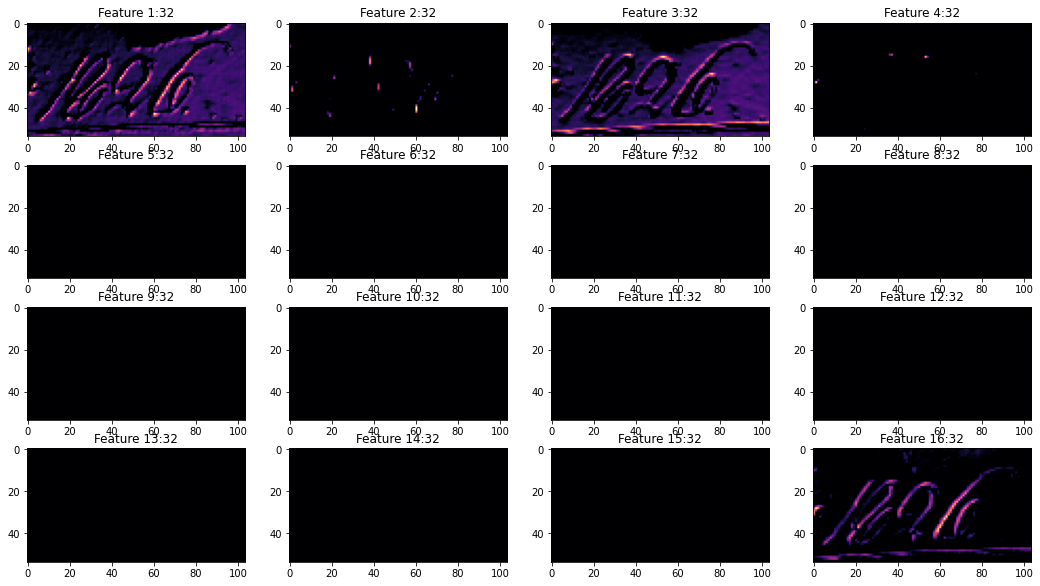

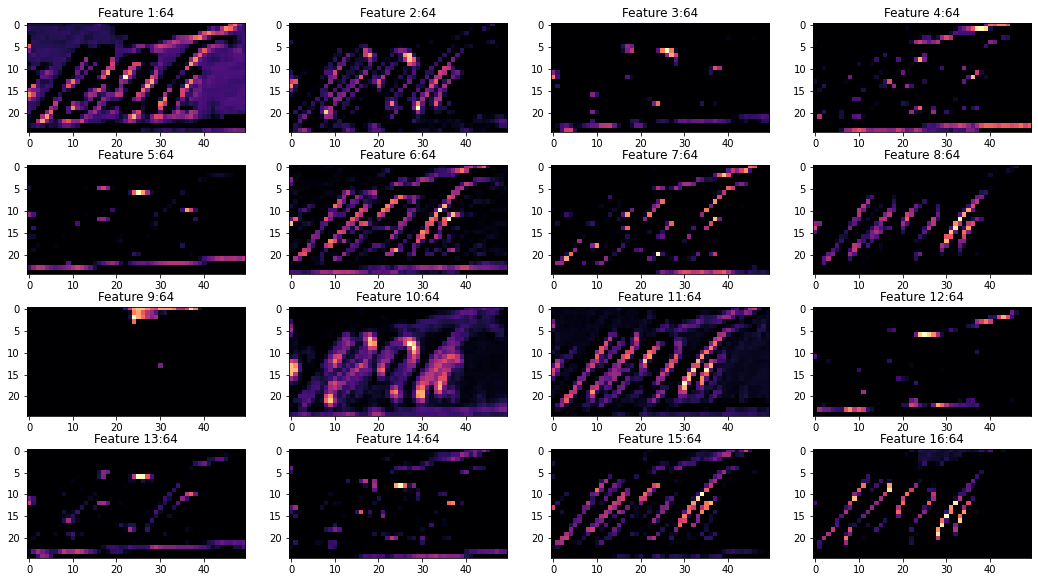

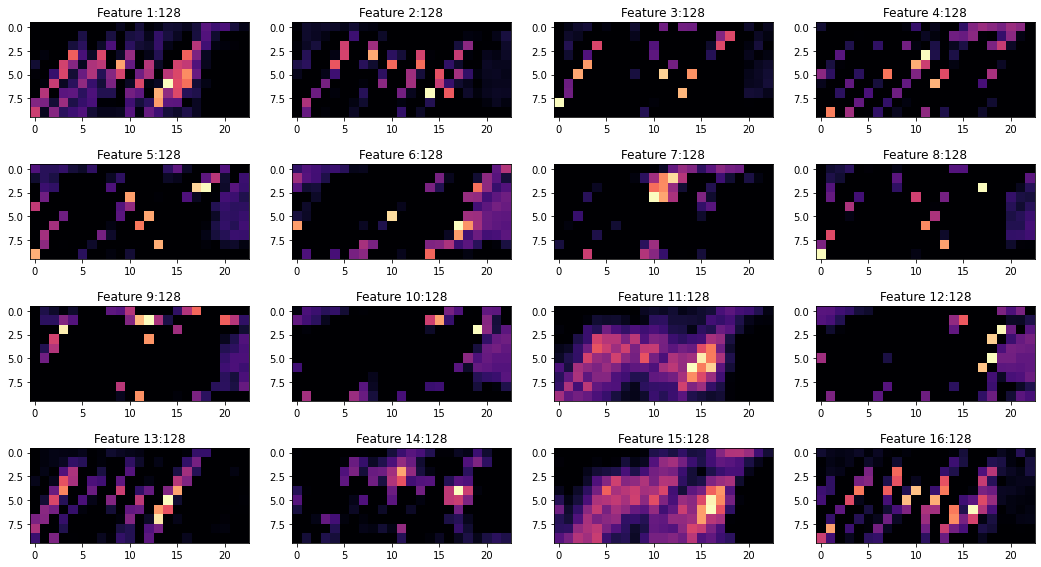

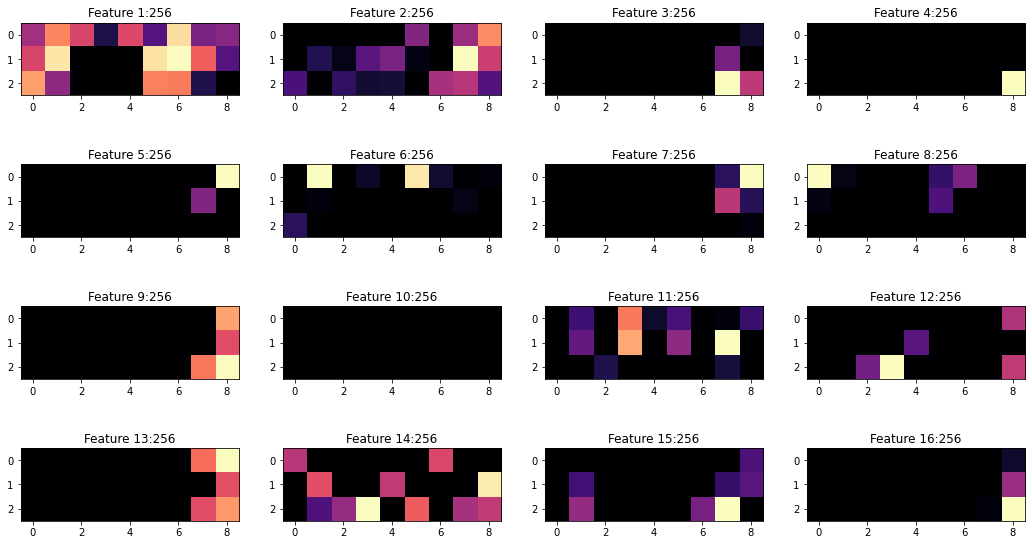

In [81]:
#Visualize feature maps for convolutional layers
layers = [visualize_layer0.predict(image), visualize_layer3.predict(image), visualize_layer6.predict(image),visualize_layer9.predict(image)]
layer_size = [32,64,128,256]
n = 0

for layer in layers:
    plt.figure(figsize=(18,10))
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.imshow(layer[0,:,:,i-1] , cmap='magma')
        layer_num = 'Feature '+str(i)+':'+str(layer_size[n])
        plt.title(layer_num)    
    n+=1
    plt.show()

In [301]:
loaded_CC.layers

### Heatmap D:

In [213]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [294]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, layer, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.layers[layer].output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

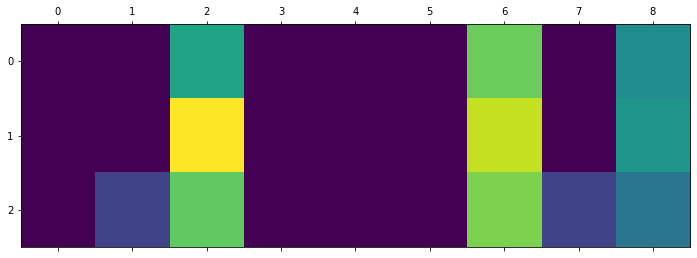

In [295]:
# Prepare image
img_array = x_test[49:50]

# Make model
model = loaded_D

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
#print(model.layers[17])
heatmap = make_gradcam_heatmap(img_array, model,11)

# Display heatmap
plt.matshow(heatmap)
plt.show()

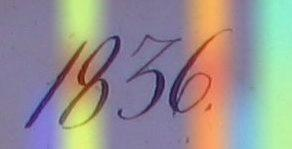

In [290]:
def save_and_display_gradcam(digits,heatmap, cam_path="cam.jpg", alpha=0.7):
    # Load the original image
    img = digits

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

image=plt.imread('DIDA_12000_String_Digit_Images/DIDA_1/50.jpg')
save_and_display_gradcam(image,heatmap)

### Heatmap Y:


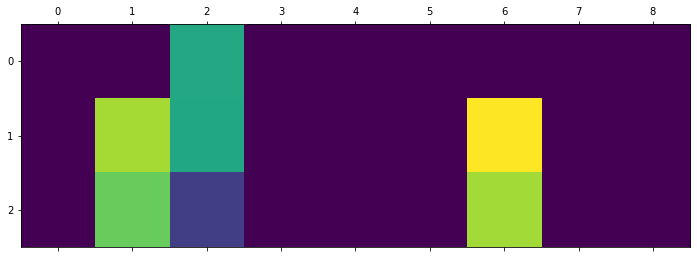

In [296]:
# Prepare image
img_array = x_test[1:2]

# Make model
model = loaded_Y

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
print(model.layers[17])
heatmap = make_gradcam_heatmap(img_array, model,13)

# Display heatmap
plt.matshow(heatmap)
plt.show()

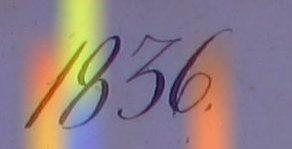

In [297]:
image=plt.imread('DIDA_12000_String_Digit_Images/DIDA_1/50.jpg')
save_and_display_gradcam(image,heatmap)

### Heatmap CC:

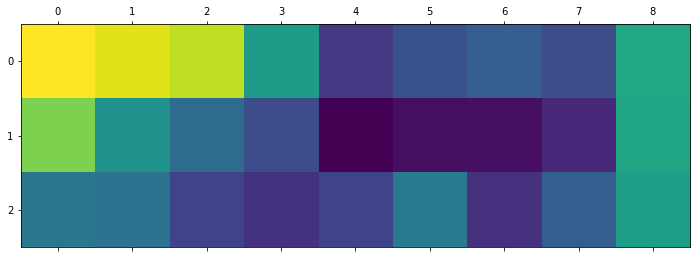

In [298]:
# Prepare image
img_array = x_test[49:50]

# Make model
model = loaded_CC

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)

# Generate class activation heatmap
print(model.layers[17])
heatmap = make_gradcam_heatmap(img_array, model,13)

# Display heatmap
plt.matshow(heatmap)
plt.show()

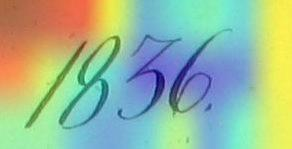

In [299]:
image=plt.imread('DIDA_12000_String_Digit_Images/DIDA_1/50.jpg')
save_and_display_gradcam(image,heatmap)

# Visualizing Filters

### Model D:

In [311]:
# tf.compat.v1.disable_eager_execution() # if we want to run the code like in the book
import numpy as np
def tidy_image(image):
    image = image.numpy()[0]
    image -= image.mean()
    image /= (image.std() + 0.00001)
    image *= 0.1
    image += 0.5
    image = np.clip(image, 0, 1)
        
    return image
    
def generate_pattern(layer_name, filter_index, im_size, model):
    #submodel = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output])
    submodel = tf.keras.models.Model([model.inputs], [model.layers[layer_name].output])
    input_img_data = np.random.random((1, *im_size))
    input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

    # Iterate gradient ascents
    for _ in range(100):
        with tf.GradientTape() as tape:
            outputs = submodel(input_img_data)
            loss_value = tf.reduce_mean(outputs[:, :, :, filter_index])
        grads = tape.gradient(loss_value, input_img_data)
        normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
        input_img_data.assign_add(normalized_grads * 1.0)
        
    return tidy_image(input_img_data)

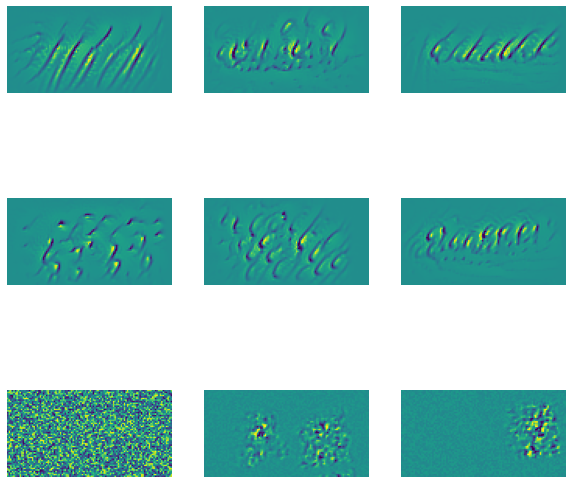

In [316]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1); plt.axis('off'); plt.imshow(generate_pattern(13, i, (56, 106, 1),loaded_Y))

In [308]:
loaded_D.layers

# Confusion Matrix

In [327]:
pred_Y = np.argmax(loaded_Y.predict(x_test))
pred_Y

19677

In [329]:
pred_Y = np.argmax(loaded_Y.predict(x_test), axis=1)
matrix = tf.math.confusion_matrix(Y_test,pred_Y)
matrix

<tf.Tensor: shape=(11, 11), dtype=int32, numpy=
array([[270,   6,   2,   1,   3,   1,   1,   1,   3,   0,   1],
       [  3, 226,   1,   1,   2,   0,   0,   1,   0,   0,   1],
       [  1,   6, 208,   2,   0,   0,   0,   0,   3,   3,   0],
       [  0,   0,   3, 196,   0,   3,   0,   1,   1,   0,   0],
       [  0,   3,   0,   3, 227,   2,   0,   0,   1,   0,   0],
       [  0,   0,   1,   2,   0, 235,   0,   0,   0,   0,   0],
       [  0,   0,   1,   0,   0,   2, 220,   0,   1,   0,   0],
       [  0,   1,   1,   0,   1,   0,   0, 233,   0,   0,   0],
       [  2,   0,   4,   0,   1,   0,   4,   0, 202,   0,   0],
       [  3,   0,  12,   2,   1,   0,   0,   2,   2, 224,   0],
       [  0,   1,   0,   0,   0,   0,   0,   1,   0,   1,  53]])>

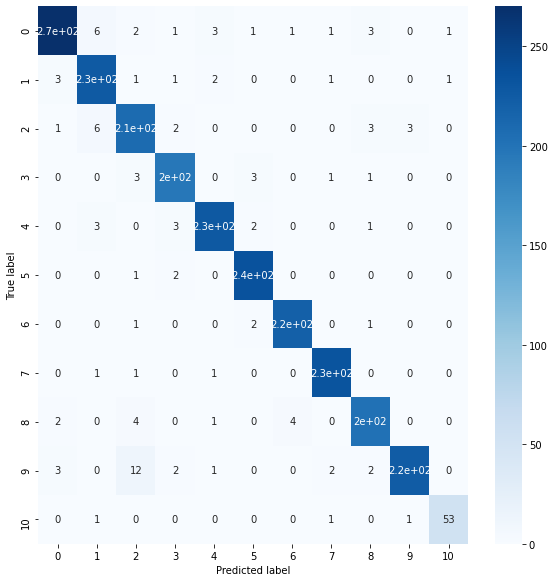

In [332]:
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

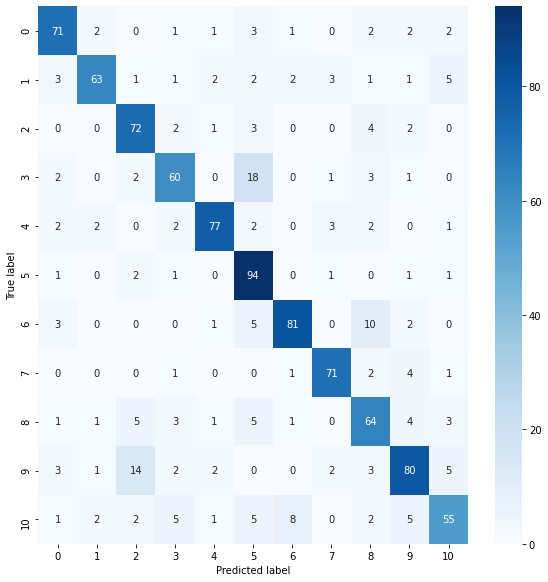

In [345]:
pred_Y = np.argmax(loaded_Y.predict(k30_img_vals), axis=1)
k30_labels_Y.astype(int)
matrix = tf.math.confusion_matrix(k30_labels_Y.astype(int),pred_Y)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

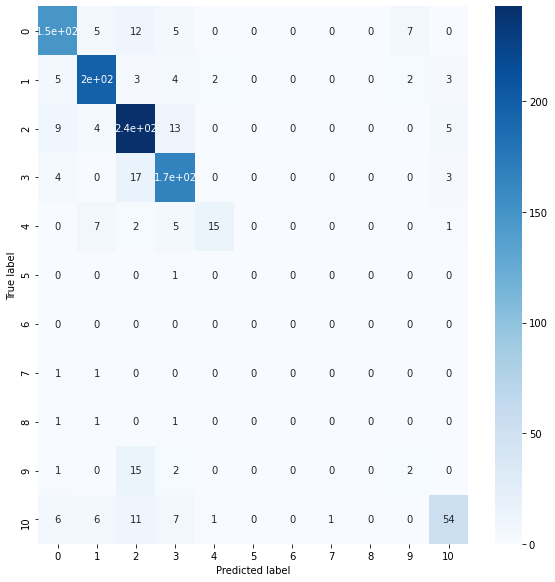

In [353]:
pred_D = np.argmax(loaded_D.predict(k30_img_vals), axis=1)
matrix = tf.math.confusion_matrix(k30_labels_D.astype(int),pred_D)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [349]:
pred_CC = np.argmax(loaded_CC.predict(k30_img_vals), axis=1)
pred_CC

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

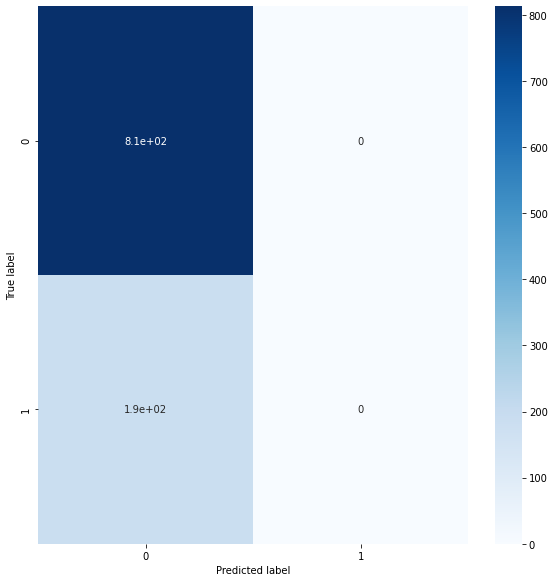

In [350]:
pred_CC = np.argmax(loaded_CC.predict(k30_img_vals), axis=1)
matrix = tf.math.confusion_matrix(k30_labels_CC.astype(int),pred_CC)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# 50/50 model 

In [32]:
data_5050 = pd.read_csv('50_50_set.csv',header=None, names=["index", "string"],delimiter=';')
data_5050['CC'] = 0
data_5050['D'] = 0
data_5050['Y'] = 0
data_5050 = data_5050.astype(str)
# Iterate string digits and append classes
for i, row in data_5050.iterrows():
    if len(row['string']) != 4:
        row['CC'] = '1'
        row['D'] = '10'
        row['Y'] = '10'
    else:
        row['D'] = row['string'][2]
        row['Y'] = row['string'][3]
        if row['string'][0:2] == '18':
            row['CC']='0'
        else:
            row['CC']='1'
print(data_5050)

     index string CC  D  Y
0      270   1920  1  2  0
1    10690   1920  1  2  0
2    10866   2021  1  2  1
3     9261   2022  1  2  2
4    10619   2025  1  2  5
..     ...    ... .. .. ..
773    401   1812  0  1  2
774    402   1813  0  1  3
775    403   1809  0  0  9
776    404   1809  0  0  9
777    405   1809  0  0  9

[778 rows x 5 columns]


In [33]:
#os.chdir(path_images)
image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1/')

# and convert to a img_df
img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                        columns=['filename', 'img_value'])
# Create proper index value in img_df to allow merge on data_5050
img_df['index'] = img_df['filename']
for i, row in img_df.iterrows():
    row['index'] = str(img_df['index'][i]).split('.')[0]
img_df
# End of creating img_df
#
# Start: merge img_df with data_5050
# match index type on dataframes to merge
data_5050['index'] = data_5050['index'].astype(int)
img_df['index'] = img_df['index'].astype(int)
# Merge dataframes
df_img_classes = data_5050.merge(img_df)
# Rearrange order of dataframe
df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
# End og merging data frames

In [34]:
df_img_classes = df_img_classes.sample(frac=1).reset_index(drop=True)
df_img_classes

,index,string,CC,D,Y,img_value,filename
0,10782,36,1,10,10,"[[[161.0], [160.0], [150.0], [142.0], [132.0],...",10782.jpg
1,52,1836,0,3,6,"[[[68.0], [72.0], [68.0], [65.0], [68.0], [66....",52.jpg
2,4288,101,1,10,10,"[[[195.0], [194.0], [193.0], [192.0], [191.0],...",4288.jpg
3,8539,1768,1,6,8,"[[[171.0], [166.0], [143.0], [67.0], [121.0], ...",8539.jpg
4,10922,40,1,10,10,"[[[158.0], [162.0], [160.0], [160.0], [161.0],...",10922.jpg
...,...,...,...,...,...,...,...
773,389,1808,0,0,8,"[[[146.0], [146.0], [147.0], [144.0], [146.0],...",389.jpg
774,6,1823,0,2,3,"[[[195.0], [194.0], [196.0], [197.0], [197.0],...",6.jpg
775,9203,232412,1,10,10,"[[[181.0], [180.0], [181.0], [179.0], [189.0],...",9203.jpg
776,132,1804,0,0,4,"[[[101.0], [104.0], [105.0], [106.0], [109.0],...",132.jpg


In [35]:
labels_CC_5050 = df_img_classes['CC']
labels_CC_5050 = labels_CC_5050.astype(np.uint8)

In [36]:
data_5050 =  df_img_classes['img_value']
values = np.zeros(shape=(len(data_5050),56,106,1))
i = 0
j = 0
while i < len(data_5050):
    values[i] = data_5050[j]
    i += 1
    j+=1
data_5050 = values/255

In [37]:
train_5050 = data_5050[0:577]
val_5050 = data_5050[578:677]
test_5050 = data_5050[678:777]
train_5050_label = labels_CC_5050[0:577]
val_5050_label = labels_CC_5050[578:677]
test_5050_label = labels_CC_5050[678:777]

In [38]:
train_5050_label

0      1
1      0
2      1
3      1
4      1
      ..
572    1
573    0
574    0
575    0
576    0
Name: CC, Length: 577, dtype: uint8

In [41]:
### With Augmentation
model_CC_5050_test = tf.keras.models.Sequential([
    data_augmentation,
    #Block 1
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(56, 106, 1)),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 2
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 3
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    #Block 4
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.SpatialDropout2D(0.5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    ])

model_CC_5050_test.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
    loss= 'binary_crossentropy',
    metrics=['accuracy'],
    ) 

In [42]:
model_5050_history = model_CC_5050_test.fit(train_5050,train_5050_label, 
                                        epochs=50,
                                        
                                        validation_data=(val_5050,val_5050_label), 
                                        validation_steps=len(val_5050),
                                        callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10))

Epoch 1/50
19/19 [==============================] - 3s 99ms/step - loss: 0.8891 - accuracy: 0.5199 - val_loss: 0.6936 - val_accuracy: 0.5354
Epoch 2/50
19/19 [==============================] - 2s 95ms/step - loss: 0.8768 - accuracy: 0.5199 - val_loss: 0.6918 - val_accuracy: 0.5354
Epoch 3/50
19/19 [==============================] - 2s 93ms/step - loss: 0.8730 - accuracy: 0.5043 - val_loss: 0.6927 - val_accuracy: 0.5354
Epoch 4/50
18/19 [===========================>..] - ETA: 0s - loss: 0.7928 - accuracy: 0.5712

KeyboardInterrupt: 

In [20]:
model_CC_5050_test.evaluate(test_5050,test_5050_label)

4/4 [==============================] - 0s 24ms/step - loss: 0.3155 - accuracy: 0.9091


[0.3155285716056824, 0.9090909361839294]

In [30]:
test_50_50_score = accuracy_calc(model_CC_5050_test,test_5050_label,test_5050)
test_50_50_score

32.99999999999996